In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, precision_score,
    recall_score, f1_score, roc_curve
)

from p2ch14.model import LunaModel
from p2ch14.dsets import LunaDataset

ModuleNotFoundError: No module named 'p2ch14'

In [ ]:
ds = p2ch14.dsets.MalignantLunaDataset(val_stride=10, isValSet_bool=True)
nodules = ds.ben_list + ds.mal_list
is_mal = torch.tensor([n.isMal_bool for n in nodules])
diam = torch.tensor([n.diameter_mm for n in nodules])
num_mal = is_mal.sum()
num_ben = len(is_mal) - num_mal

2025-07-16 16:51:50,282 INFO     pid:25088 p2ch14.dsets:279:__init__ <p2ch14.dsets.MalignantLunaDataset object at 0x00000190DF5D3130>: 51583 validation samples, 51429 neg, 154 pos, unbalanced ratio


[pylidc] Loading malignancy info...
[pylidc] Loaded benign: 0, malignant: 0, negative: 549714


2025-07-17 09:58:09,933 INFO     pid:4576 p2ch14.dsets:279:__init__ <p2ch14.dsets.LunaDataset object at 0x000002A0FF787F70>: 51583 validation samples, 51429 neg, 154 pos, unbalanced ratio
100%|██████████| 6448/6448 [00:45<00:00, 140.53it/s]


[Confusion Matrix]
[[50765   664]
 [    5   149]]

[Classification Report]
              precision    recall  f1-score   support

           0     0.9999    0.9871    0.9935     51429
           1     0.1833    0.9675    0.3082       154

    accuracy                         0.9870     51583
   macro avg     0.5916    0.9773    0.6508     51583
weighted avg     0.9975    0.9870    0.9914     51583



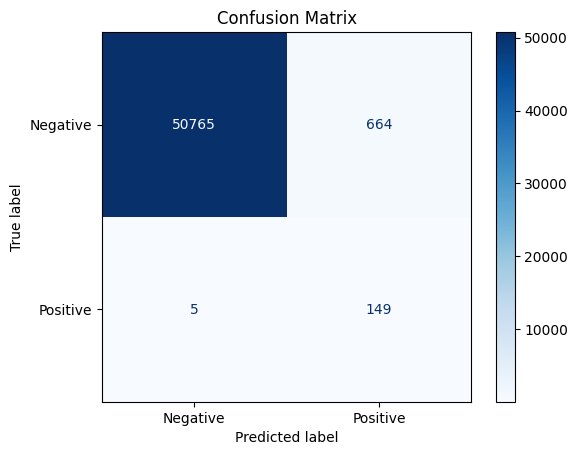


[INFO] 저장된 TP 결절 수: 149


In [ ]:
# 1. 모델 로딩
model = LunaModel()
device = torch.device("cuda")
model = model.to(device)
model_path = "data-unversioned/part2/models/p2ch14/cls_2025-07-14_09.09.08_dlwpt.2000000.state"
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state'])
model.eval()

# 2. Validation 데이터 로더
val_ds = LunaDataset(isValSet_bool=True, val_stride=10)
val_loader = DataLoader(val_ds, batch_size=8, num_workers=0)

# 3. 예측 및 결과 저장
y_true = []
y_pred = []
y_prob = []
predicted_nodules = []

with torch.no_grad():
    for data, label, series_list, center_list, *_ in tqdm(val_loader):
        data = data.to(device)
        output = model(data)

        if isinstance(output, tuple):
            output = output[0]

        probs = F.softmax(output, dim=1).detach().cpu().numpy()
        labels = label.argmax(dim=1).cpu().numpy()
        preds = (probs[:, 1] > 0.5).astype(int)

        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())
        y_prob.extend(probs[:, 1].tolist())

        for prob_score, true_label, pred_label, series_uid, center_xyz in zip(
            probs[:, 1], labels, preds, series_list, center_list
        ):
            if true_label == 1 and pred_label == 1:
                predicted_nodules.append({
                    'series_uid': series_uid,
                    'center_xyz': center_xyz,
                    'probability': prob_score
                })

# 4. 혼동 행렬 출력
cm = confusion_matrix(y_true, y_pred)
print("[Confusion Matrix]")
print(cm)

print("\n[Classification Report]")
print(classification_report(y_true, y_pred, digits=4))

# 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

# 5. TP 저장
with open("predicted_nodules_base.pkl", "wb") as f:
    pickle.dump(predicted_nodules, f)

print(f"\n[INFO] 저장된 TP 결절 수: {len(predicted_nodules)}")


In [ ]:
# 1. 모델 로딩
model = LunaModel()
device = torch.device("cuda")
model = model.to(device)

model_path = "data-unversioned/part2/models/p2ch14/cls_2025-07-14_09.09.08_dlwpt.2000000.state"
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state'])
model.eval()

# 2. Validation 데이터 로더
val_ds = LunaDataset(isValSet_bool=True, val_stride=10)
val_loader = DataLoader(val_ds, batch_size=8, num_workers=0)

# 3. 예측 및 결과 저장
predicted_nodules = []

with torch.no_grad():
    for data, label, series_list, center_list, *_ in tqdm(val_loader):
        data = data.to(device)
        output = model(data)

        if isinstance(output, tuple):
            output = output[0]

        prob = F.softmax(output, dim=1).detach().cpu().numpy()
        positive_probs = prob[:, 1].tolist()
        labels = label.argmax(dim=1).cpu().numpy().tolist()
        preds = [1 if p > 0.5 else 0 for p in positive_probs]

        for prob_score, true_label, pred_label, series_uid, center_xyz in zip(
            positive_probs, labels, preds, series_list, center_list
        ):
            if true_label == 1 and pred_label == 1:
                predicted_nodules.append({
                    'series_uid': series_uid,
                    'center_xyz': center_xyz,
                    'probability': prob_score
                })

# 4. 저장
with open("predicted_nodules_base.pkl", "wb") as f:
    pickle.dump(predicted_nodules, f)

print(f"[INFO] 저장된 결절 수: {len(predicted_nodules)}")

2025-07-17 09:27:40,219 INFO     pid:4576 p2ch14.dsets:279:__init__ <p2ch14.dsets.LunaDataset object at 0x000002A09793E920>: 51583 validation samples, 51429 neg, 154 pos, unbalanced ratio
100%|██████████| 6448/6448 [00:42<00:00, 151.23it/s]

[INFO] 저장된 결절 수: 149


In [ ]:
# 모델 로딩
model = LunaModel()
device = torch.device("cuda")
model.load_state_dict(torch.load("data-unversioned/part2/models/p2ch14/cls_2025-07-14_09.09.08_dlwpt.2000000.state", map_location=device)['model_state'])
model = model.to(device).eval()

# 데이터 로더
val_ds = LunaDataset(isValSet_bool=True, val_stride=10)
val_loader = DataLoader(val_ds, batch_size=8, num_workers=0)

# 결과 저장
predicted_nodules = []

with torch.no_grad():
    for data, label, _, series_list, center_list in tqdm(val_loader):
        data = data.to(device)
        output = model(data)

        if isinstance(output, tuple):
            output = output[0]

        probs = F.softmax(output, dim=1).detach().cpu().numpy()
        labels = label.argmax(dim=1).cpu().numpy()
        preds = (probs[:, 1] > 0.5).astype(int)

        for prob_score, true_label, pred_label, series_uid, center_xyz in zip(
            probs[:, 1], labels, preds, series_list, center_list
        ):
            # 🔒 여기서 series_uid는 이미 문자열 UID임 (수정 불필요)
            if true_label == 1 and pred_label == 1:
                predicted_nodules.append({
                    'series_uid': str(series_uid),  # 안전하게 문자열로 변환
                    'center_xyz': center_xyz.tolist(),  # numpy 호환
                    'probability': float(prob_score)
                })

# 저장
with open("predicted_nodules_fixed.pkl", "wb") as f:
    pickle.dump(predicted_nodules, f)

print(f"[INFO] 저장 완료: 총 {len(predicted_nodules)}개 True Positive")

2025-07-17 09:44:25,859 INFO     pid:4576 p2ch14.dsets:279:__init__ <p2ch14.dsets.LunaDataset object at 0x000002A0DFA6C340>: 51583 validation samples, 51429 neg, 154 pos, unbalanced ratio
100%|██████████| 6448/6448 [00:51<00:00, 124.47it/s]

[INFO] 저장 완료: 총 149개 True Positive


In [ ]:
# 1. 수정된 pickle 불러오기
with open("predicted_nodules_fixed.pkl", "rb") as f:
    predicted_nodules = pickle.load(f)

# 2. GT 로딩
anno_df = pd.read_csv("data/part2/luna/annotations_with_malignancy.csv")
anno_df = anno_df.rename(columns={'seriesuid': 'series_uid', 'mal_bool': 'malignancy'})
anno_df['series_uid'] = anno_df['series_uid'].astype(str).str.strip()

# 3. GT 딕셔너리화
gt_coords_by_uid = {}
for _, row in anno_df.iterrows():
    uid = row['series_uid']
    coord = (row['coordX'], row['coordY'], row['coordZ'])
    malignancy = row['malignancy']
    gt_coords_by_uid.setdefault(uid, []).append((coord, malignancy))

# 4. 매칭
output_rows = []

for pred in predicted_nodules:
    uid = pred['series_uid']
    prob = pred['probability']
    cx, cy, cz = pred['center_xyz'][:3]
    pred_xyz = np.array([[cx, cy, cz]])

    if uid not in gt_coords_by_uid:
        output_rows.append({
            'series_uid': uid,
            'centerX': cx,
            'centerY': cy,
            'centerZ': cz,
            'probability': prob,
            'matched': False,
            'malignancy': None
        })
        continue

    gt_coords = np.array([xyz for xyz, _ in gt_coords_by_uid[uid]])
    malignancies = [mal for _, mal in gt_coords_by_uid[uid]]
    distances = cdist(pred_xyz, gt_coords).flatten()
    min_idx = distances.argmin()
    matched_malignancy = malignancies[min_idx]

    output_rows.append({
        'series_uid': uid,
        'centerX': cx,
        'centerY': cy,
        'centerZ': cz,
        'probability': prob,
        'matched': True,
        'malignancy': matched_malignancy
    })

# 5. 저장
df_out = pd.DataFrame(output_rows)
df_out.to_csv("matched_and_unmatched.csv", index=False)

# 6. 통계
matched_df = df_out[df_out['matched']]
print(f"[Matched: {len(matched_df)} / {len(df_out)}]")
print(f"  ▸ 악성: {matched_df['malignancy'].sum()}")
print(f"  ▸ 양성: {(matched_df['malignancy'] == 0).sum()}")
print(f"  ▸ 매칭 실패: {len(df_out) - len(matched_df)}")

[Matched: 149 / 149]
  ▸ 악성: 57
  ▸ 양성: 92
  ▸ 매칭 실패: 0


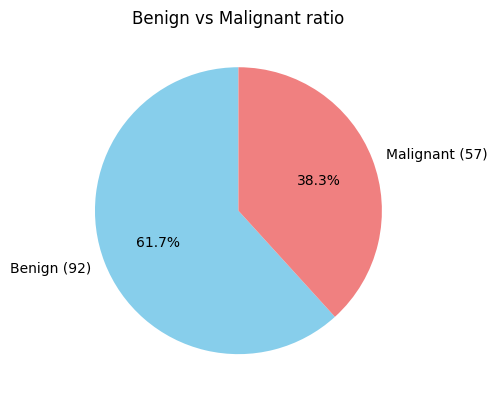

In [ ]:
labels = ['Benign (92)', 'Malignant (57)']
sizes = [92, 57]
colors = ['skyblue', 'lightcoral']

plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Benign vs Malignant ratio')
plt.tight_layout()
plt.savefig('malignancy_pie.png')
plt.show()

### 데이터 증강

In [ ]:
model.eval()
y_true = []
y_score = []

num_aug = 0
num_samples = 0

with torch.no_grad():
    for data, label, *_ in tqdm(val_loader):
        data = data.to(device)
        label = label.to(device)

        batch_size = data.size(0)

        for i in range(batch_size):
            x = data[i].unsqueeze(0)  # [1, C, H, W]
            l = label[i].argmax().item()  # 0 or 1

            preds = []

            if l == 1:
                # 양성인 경우만 2개 증강 (원본 + 좌우반전)
                aug_funcs = [
                    lambda x: x,
                    lambda x: torch.flip(x, dims=[-1])
                ]
                for aug in aug_funcs:
                    x_aug = aug(x)
                    out = model(x_aug)
                    if isinstance(out, tuple):
                        out = out[0]
                    preds.append(out)
                    num_aug += 1
            else:
                # 음성은 원본만
                out = model(x)
                if isinstance(out, tuple):
                    out = out[0]
                preds.append(out)

            # 평균
            output_avg = torch.stack(preds).mean(dim=0)
            prob = torch.sigmoid(output_avg).detach().cpu().numpy().squeeze()

            y_score.append(prob[1])  # 긍정 클래스 확률
            y_true.append(l)

            num_samples += 1

# 로그 출력
print(f"\n[Inference Summary]")
print(f" 총 원본 샘플 수      : {num_samples}")
print(f" 전체 추론 횟수       : {num_aug}회 (양성만 증강 적용)")

100%|██████████| 6448/6448 [01:44<00:00, 61.82it/s]


[Inference Summary]
 총 원본 샘플 수      : 51583
 전체 추론 횟수       : 308회 (양성만 증강 적용)


In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_score)
youden_index = tpr - fpr
best_threshold = thresholds[np.argmax(youden_index)]

# 2. 예측 라벨 생성
y_pred = [1 if s > best_threshold else 0 for s in y_score]

# 3. 혼동행렬 및 지표
cm = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# 4. 출력
print(f"\n[Evaluation Metrics @ Best Threshold (Youden’s Index)]")
print(f" Best threshold: {best_threshold:.4f}")
print("\n Confusion Matrix:")
print(cm)
print(f"\n Precision: {precision:.4f}")
print(f" Recall:    {recall:.4f}")
print(f" F1-score:  {f1:.4f}")


[Evaluation Metrics @ Best Threshold (Youden’s Index)]
 Best threshold: 0.1444

 Confusion Matrix:
[[50589   840]
 [    6   148]]

 Precision: 0.1498
 Recall:    0.9610
 F1-score:  0.2592



 Best threshold (Youden's Index): 0.1444

 Confusion Matrix:
[[50589   840]
 [    6   148]]

 Precision: 0.1498
 Recall:    0.9610
 F1-score:  0.2592


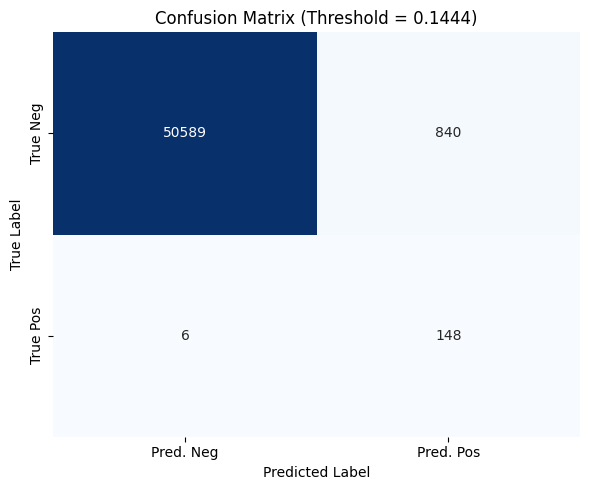

In [ ]:
# 1. y_true, y_score 차원 조정 (필수!)
y_true = np.array(y_true).ravel()
y_score = np.array(y_score).ravel()

# 2. ROC 계산
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# 3. Youden's Index
youden_index = tpr - fpr
best_threshold = thresholds[np.argmax(youden_index)]
print(f"\n Best threshold (Youden's Index): {best_threshold:.4f}")

# 4. 이진 예측
y_pred_best = (y_score > best_threshold).astype(int)

# 5. 평가 지표
cm = confusion_matrix(y_true, y_pred_best)
precision = precision_score(y_true, y_pred_best)
recall = recall_score(y_true, y_pred_best)
f1 = f1_score(y_true, y_pred_best)

print("\n Confusion Matrix:")
print(cm)
print(f"\n Precision: {precision:.4f}")
print(f" Recall:    {recall:.4f}")
print(f" F1-score:  {f1:.4f}")

# 6. 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Pred. Neg", "Pred. Pos"],
            yticklabels=["True Neg", "True Pos"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Threshold = {:.4f})".format(best_threshold))
plt.tight_layout()
plt.show()